#### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model,metrics
from sklearn.metrics import f1_score
from sklearn import naive_bayes
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn import svm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from xgboost import XGBClassifier

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Loading the data

In [3]:
dataset=pd.read_csv(r'dataset\bank-additional-full.csv',delimiter=';')

In [4]:
dataset.shape

(41188, 21)

In [5]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Map Target values

In [6]:
dataset['y']=dataset['y'].map({'yes':1,'no':0})

#### Counting unknown values

In [7]:
for i in dataset.columns:
    if dataset[i].dtype ==object:
        count_unkown = dataset[i].str.count('unknown').sum()
        print('column',i,'has',count_unkown,'unknown values.')

column job has 330 unknown values.
column marital has 80 unknown values.
column education has 1731 unknown values.
column default has 8597 unknown values.
column housing has 990 unknown values.
column loan has 990 unknown values.
column contact has 0 unknown values.
column month has 0 unknown values.
column day_of_week has 0 unknown values.
column poutcome has 0 unknown values.


#### Remove the unknown values 

In [9]:
dataset=dataset[(dataset['job']!='unknown')&(dataset['marital']!='unknown')&(dataset['education']!='unknown')&(dataset['default']!='unknown')&(dataset['housing']!='unknown')&(dataset['loan']!='unknown')]
print(dataset.shape)

(30488, 20)


In [8]:
# Drop duration column
dataset.drop(['duration'],axis=1,inplace=True)


#### Convert categorical values to encoded values

In [10]:
categorical_col=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for item in categorical_col:
    dataset[item]=dataset[item].astype('category')
cat_columns = dataset.select_dtypes(['category']).columns
dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)


In [11]:
dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,1,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,1,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
6,59,0,1,5,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,5,0,1,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,1,1,5,0,0,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5,1,6,0,1,0,0,7,0,2,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,9,1,5,0,0,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1


#### Checking the target class

In [12]:
dataset['y'].value_counts()

0    26629
1     3859
Name: y, dtype: int64

<AxesSubplot:>

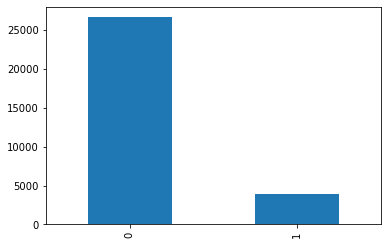

In [55]:
dataset['y'].value_counts().plot(kind='bar')

#### Downsampling the majority class 
The class 1 is low in number compared to the class 0. There is imbalance in the target class.<br> 
The dataset is downsampled to reduce this imbalance.

In [13]:
np.random.seed(0)
dataset_classyes=dataset[dataset['y']==1]
dataset_classno=dataset[dataset['y']==0]

sample=np.random.choice([True, False], len(dataset_classno), replace=True, p=[0.25, 0.75])
#downsample dataset with class value 'no' 
dataset_classno_downsampled=dataset_classno[sample]
print(dataset_classyes.shape)
print(dataset_classno_downsampled.shape)

finaldf = pd.concat([dataset_classno_downsampled,dataset_classyes])
print(finaldf.shape)

(3859, 20)
(6785, 20)
(10644, 20)


## Feature scaling

In [14]:
mmScaler = MinMaxScaler()

In [15]:
finaldf = pd.DataFrame(mmScaler.fit_transform(finaldf),
                                  columns=finaldf.columns)
        

## Feature engineering

#### Using RandomForest Classifier to find the feature importance

In [16]:
X=finaldf.iloc[:,:-1] #all independent variables
y=finaldf.iloc[:,-1] #target variable
fit_rf=RandomForestClassifier(random_state=0)

#### Using GridSearch for hyperparameter tuning

In [ ]:
np.random.seed(0)
param_dist = {'max_depth':[2,3,4],
             'bootstrap':[True, False],
              'n_estimators':[10,50,100],
             'max_features':['auto','sqrt','log2',None],
             'criterion':['gini','entropy']}

cv_rf = GridSearchCV(fit_rf,cv=10,param_grid=param_dist,n_jobs=3)

cv_rf.fit(X,y)

print('Best parameters using grid search: \n',
     cv_rf.best_params_)

Run Random Forest classifier for feature selection

In [17]:
fit_rf.set_params(criterion='gini',n_estimators = 100,max_features='auto',max_depth=2,bootstrap=True)
fit_rf.fit(X,y)

def variable_importance(fit):
    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance':importances,'index':indices}

var_imp_rf=variable_importance(fit_rf)
importances_rf=var_imp_rf['importance']
indices_rf=var_imp_rf['index']

print('Feature ranking:')
feature_name=['age','job','marital','education','default','housing','loan','contact','month','day_of_week',
              'campaign','pdays','previous','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']


for i in range(0,indices_rf.shape[0]):
    f = i
    print('{0}. {1} - importance={2}'.format(f+1,feature_name[indices_rf[i]],round(importances_rf[indices_rf[f]],2)))


Feature ranking:
1. nr.employed - importance=0.31
2. euribor3m - importance=0.18
3. pdays - importance=0.13
4. emp.var.rate - importance=0.13
5. poutcome - importance=0.08
6. cons.conf.idx - importance=0.08
7. previous - importance=0.03
8. month - importance=0.02
9. cons.price.idx - importance=0.02
10. contact - importance=0.01
11. age - importance=0.01
12. campaign - importance=0.0
13. marital - importance=0.0
14. day_of_week - importance=0.0
15. education - importance=0.0
16. job - importance=0.0
17. loan - importance=0.0
18. housing - importance=0.0
19. default - importance=0.0


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
feature_train, feature_test, target_train, target_test = train_test_split(X, y, test_size=0.4, random_state=2018, stratify = y)

In [20]:
X.shape, y.shape

((10644, 19), (10644,))

In [21]:
feature_train.shape,feature_test.shape,target_train.shape,target_test.shape

((6386, 19), (4258, 19), (6386,), (4258,))

### Models

In [47]:
class Model:
    """
    class for model building
    """
    
    def __init__(self):
            pass
        
    def logReg(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()

        # split data index to train and test
        for train, test in kfold.split(X_train):
            # specify train and test sets
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            # initialize the model
            model = linear_model.LogisticRegression(random_state=2018)
            # train
            model.fit(x_train, y_train)
            # predict for evaluation
            preds = model.predict(x_test)
            # compute f1-score
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))
        return model, scores, test_pred
    
    def naiveBayes(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train):     
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = naive_bayes.GaussianNB()
            # train
            model.fit(x_train, y_train)
            # predict for evaluation
            preds = model.predict(x_test)
            # compute f1-score
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))
        return model, scores, test_pred    
   
    def linearsvm(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train):     
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = svm.SVC(kernel='linear', C=10)
            # train
            model.fit(x_train, y_train)
            # predict for evaluation
            preds = model.predict(x_test)
            # compute f1-score
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))
        return model, scores, test_pred
    
    def rbfsvm(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train):     
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = svm.SVC(kernel='rbf', C=10)
            # train
            model.fit(x_train, y_train)
            # predict for evaluation
            preds = model.predict(x_test)
            # compute f1-score
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))
        return model, scores, test_pred
    
    def polysvm(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train):     
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = svm.SVC(kernel='poly', C=10)
            # train
            model.fit(x_train, y_train)
            # predict for evaluation
            preds = model.predict(x_test)
            # compute f1-score
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))
        return model, scores, test_pred
    
    def Xgb(self, X_train, X_val, Y_train, Y_val):
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train):     
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = XGBClassifier(random_state=2018,  n_estimators=800,  learning_rate=0.1,
                              objective='binary:logistic')
            eval_set  = [(x_train,y_train), (x_test,y_test)]
            model.fit(x_train, y_train, eval_set=eval_set, eval_metric="auc", verbose=400)
            preds = model.predict(x_test)
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            pred_tot_cb.append(test_pred)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))

        return model, scores, test_pred
        



    def randomForest(self, X_train, X_val, Y_train, Y_val):
        from sklearn.ensemble import RandomForestClassifier
        kfold, scores = KFold(n_splits=5, shuffle=True, random_state=2018), list()
        pred_tot_cb = []
        for train, test in kfold.split(X_train): 
            x_train, x_test = X_train.iloc[train], X_train.iloc[test]
            y_train, y_test = Y_train.iloc[train], Y_train.iloc[test]

            model = RandomForestClassifier(n_estimators=300)
            model.fit(x_train, y_train)
            preds = model.predict(x_test)
            score = f1_score(y_test, preds)
            scores.append(score)
            test_pred = model.predict(X_val)
            pred_tot_cb.append(test_pred)
            print('f1-score: ',score)
        print("Average: ", sum(scores)/len(scores))

        return model, scores, test_pred
    


In [48]:
classifier = Model()

In [49]:
featurecols = ['nr.employed', 'euribor3m','pdays','emp.var.rate','poutcome',
               'cons.conf.idx','previous','month','cons.price.idx','contact','age']

In [50]:
bank_train = feature_train[featurecols]
bank_test = feature_test[featurecols]

In [26]:
bank_train.shape, bank_test.shape

((6386, 11), (4258, 11))

In [27]:
logit_model, scores, prediction = classifier.logReg(bank_train, bank_test, target_train, target_test)

f1-score:  0.6359223300970873
f1-score:  0.661271676300578
f1-score:  0.6508135168961201
f1-score:  0.6305418719211823
f1-score:  0.6493506493506493
Average:  0.6455800089131234


In [28]:
nb_model, scores, prediciton = classifier.naiveBayes(bank_train, bank_test, target_train, target_test)

f1-score:  0.6039119804400978
f1-score:  0.6080760095011877
f1-score:  0.5872442839951865
f1-score:  0.5753086419753086
f1-score:  0.6144859813084113
Average:  0.5978053794440383


In [29]:
linearsvm_model, scores, prediction = classifier.linearsvm(bank_train, bank_test, target_train, target_test)

f1-score:  0.6341463414634146
f1-score:  0.6248431618569636
f1-score:  0.6210526315789473
f1-score:  0.6287787182587666
f1-score:  0.6122961104140526
Average:  0.624223392714429


In [30]:
rbfsvm_model, scores, prediction = classifier.rbfsvm(bank_train, bank_test, target_train, target_test)

f1-score:  0.6799065420560748
f1-score:  0.6848072562358276
f1-score:  0.6802884615384616
f1-score:  0.6380952380952382
f1-score:  0.675990675990676
Average:  0.6718176347832556


In [51]:
polysvm_model, scores, prediction = classifier.polysvm(bank_train, bank_test, target_train, target_test)

f1-score:  0.6830409356725147
f1-score:  0.6825396825396824
f1-score:  0.6825775656324582
f1-score:  0.6386554621848739
f1-score:  0.677570093457944
Average:  0.6728767478974945


In [31]:
rf_model, rf_scores, random_prediction = classifier.randomForest(bank_train, bank_test, target_train, target_test)

f1-score:  0.6447219069239501
f1-score:  0.6572052401746724
f1-score:  0.6471962616822429
f1-score:  0.6042154566744731
f1-score:  0.6261261261261262
Average:  0.635892998316293


In [32]:
xgb_model, scores, prediction = classifier.Xgb(bank_train, bank_test, target_train, target_test)

[0]	validation_0-auc:0.80596	validation_1-auc:0.80381
[400]	validation_0-auc:0.90758	validation_1-auc:0.79482
[799]	validation_0-auc:0.93166	validation_1-auc:0.77843
f1-score:  0.6511056511056511
[0]	validation_0-auc:0.80665	validation_1-auc:0.80883
[400]	validation_0-auc:0.91483	validation_1-auc:0.79294
[799]	validation_0-auc:0.93226	validation_1-auc:0.78169
f1-score:  0.6776084407971863
[0]	validation_0-auc:0.81252	validation_1-auc:0.79225
[400]	validation_0-auc:0.90673	validation_1-auc:0.80457
[799]	validation_0-auc:0.92870	validation_1-auc:0.79302
f1-score:  0.6548672566371682
[0]	validation_0-auc:0.81279	validation_1-auc:0.77541
[400]	validation_0-auc:0.91394	validation_1-auc:0.75938
[799]	validation_0-auc:0.93416	validation_1-auc:0.74898
f1-score:  0.6309226932668328
[0]	validation_0-auc:0.81032	validation_1-auc:0.78732
[400]	validation_0-auc:0.91324	validation_1-auc:0.79037
[799]	validation_0-auc:0.93425	validation_1-auc:0.77980
f1-score:  0.6356968215158924
Average:  0.65004017

In [52]:
from sklearn.metrics import recall_score, f1_score
models = [xgb_model, logit_model, polysvm_model,linearsvm_model, rbfsvm_model,rf_model]
recall_score_list, f1_score_list = [], []
for model in models:
    score = recall_score(target_test, model.predict(bank_test))
    recall_score_list.append(score)
    score = f1_score(target_test, model.predict(bank_test))
    f1_score_list.append(score)

In [53]:
# concat models and score
model_names = ['XGBoost', 'Logistic Regression', 'SVM (Polynomial Kernel)', 'SVM (Linear Kernel)', 'SVM (RBF Kernel)','Random Forest']
model_score = zip(model_names, recall_score_list, f1_score_list)
model_score = pd.DataFrame(data=model_score, columns=['Model Names', 'Recall Score', 'F1-Score'])
model_score

,Model Names,Recall Score,F1-Score
0,XGBoost,0.550518,0.628931
1,Logistic Regression,0.579016,0.649237
2,SVM (Polynomial Kernel),0.630181,0.682089
3,SVM (Linear Kernel),0.496762,0.605367
4,SVM (RBF Kernel),0.627591,0.680239
5,Random Forest,0.552461,0.596295


In [54]:
### conclusion: The top 3 models (in terms of Recall) - 
model_score.sort_values('Recall Score', ascending=False)[:3]

,Model Names,Recall Score,F1-Score
2,SVM (Polynomial Kernel),0.630181,0.682089
4,SVM (RBF Kernel),0.627591,0.680239
1,Logistic Regression,0.579016,0.649237
